In [1]:
import torch
import torchvision
from torch import nn 
#from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image 
#%matplotlib inline
import numpy as np
import dataset_utils
import importlib
import pickle
importlib.reload(dataset_utils)


<module 'dataset_utils' from '/home/fogliodicarta/Desktop/InsectClassification/dataset_utils.py'>

In [2]:
import modelCspectral as m
def extract_features(self,x):
    x = self.main(x)
    x = self.flatten(x)
    return x
m.Discriminator.extract_features = extract_features

discriminator = m.Discriminator()
discriminator.cuda()
generator = m.Generator(noise_size=100)
generator.cuda()

Generator(
  (embed): Embedding(1050, 50)
  (main): Sequential(
    (0): Tpose(
      (main): Sequential(
        (0): ConvTranspose2d(150, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (1): Tpose(
      (main): Sequential(
        (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (2): Tpose(
      (main): Sequential(
        (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (3

In [4]:
g_dict = torch.load('checkpoints/generatorCSpectralNormEmbedding50')
generator.load_state_dict(g_dict['model_state_dict'])
d_dict = torch.load('checkpoints/discriminatorCSpectralNormEmbedding50')
discriminator.load_state_dict(d_dict['model_state_dict'])

<All keys matched successfully>

In [5]:
fixed_latent = torch.randn(200, 100, 1, 1).cuda()
#sample_random_classes = torch.tensor(np.random.randint(0, 1050, fixed_latent.shape[0])).cuda()
sample_random_classes = 3*torch.ones(fixed_latent.shape[0],dtype=int).cuda()
save_p = dataset_utils.Save_samples_params(fixed_latent,sample_random_classes,'generated')
dataset_utils.save_samples(0,save_p,generator,None,)

AttributeError: 'NoneType' object has no attribute 'add_image'

In [6]:
df = pd.read_csv('final_dataset.csv',index_col=0)
tform = transforms.Compose([transforms.Resize((64,64)),transforms.PILToTensor(),transforms.ConvertImageDtype(torch.float),transforms.Normalize(0.5,0.5)])
image_dataset = torchvision.datasets.ImageFolder("image_dataset/",transform=tform)
species2genus = dataset_utils.species_label_to_genus_label(df,image_dataset)


In [7]:
image_dataset.class_to_idx

{'Abax_parallelepipedus': 0,
 'Abax_parallelus': 1,
 'Acleris_chalybeana': 2,
 'Acleris_macdunnoughi': 3,
 'Acordulecera_dorsalis': 4,
 'Acrolophus_forbesi': 5,
 'Acrolophus_kearfotti': 6,
 'Acronicta_alni': 7,
 'Acronicta_grisea': 8,
 'Acronicta_increta': 9,
 'Acronicta_modica': 10,
 'Acronicta_psi': 11,
 'Acronicta_rumicis': 12,
 'Adalia_decempunctata': 13,
 'Adelpha_iphicleola': 14,
 'Adelpha_iphiclus': 15,
 'Adelpha_leucophthalma': 16,
 'Adelpha_lorzae': 17,
 'Adelpha_melanthe': 18,
 'Adelpha_salmonides': 19,
 'Adelpha_tracta': 20,
 'Adrastus_pallens': 21,
 'Aedes_aegypti': 22,
 'Aedes_albopictus': 23,
 'Aedes_euplocamus': 24,
 'Aedes_vexans': 25,
 'Agabus_bipustulatus': 26,
 'Agabus_infuscatus': 27,
 'Agabus_sturmii': 28,
 'Agabus_uliginosus': 29,
 'Agonum_emarginatum': 30,
 'Agonum_fuliginosum': 31,
 'Agonum_lugens': 32,
 'Agonum_marginatum': 33,
 'Agonum_micans': 34,
 'Agonum_muelleri': 35,
 'Agonum_sexpunctatum': 36,
 'Agonum_viduum': 37,
 'Agriophara_confertella': 38,
 'Agriop

In [19]:
batch_size = 1000 
import random
import dataset_utils
img2dna = dataset_utils.get_imgs_bold_id(image_dataset,df)

nucleotides = df[['nucleotide','species_name','genus_name','processid','image_urls']]
colonna_dna = df.loc[:,"nucleotide"]
nucleotides.loc[:,'nucleotide'] = colonna_dna.apply(dataset_utils.one_hot_encoding)
random.seed(42)

X_train_1, X_test, y_train_1, y_test = dataset_utils.data_split(nucleotides,0.2,random_state=42)
print(y_test)
train_data = X_train_1
train_data['species_name'] = y_train_1

X_train, X_validation, y_train, y_validation = dataset_utils.data_split(train_data,0.2,drop_labels=False,random_state=42)
train_indices, val_indices, test_indices = dataset_utils.image_splits_from_df(X_train,X_validation,X_test,image_dataset)
from torch.utils.data import Dataset, DataLoader
 
class WholeDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.targets = data.targets#torch.tensor(targets)
        #self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index][0]
        y = self.targets[index]
        
        return x, y
    
    def __len__(self):
        return len(self.data)
        
whole_dataset = WholeDataset(image_dataset)
n_classes = np.unique(whole_dataset.targets).shape[0]
print(len(test_indices+val_indices+train_indices))
len(whole_dataset)

train_imgs = torch.utils.data.Subset(whole_dataset, train_indices)
val_imgs = torch.utils.data.Subset(whole_dataset, val_indices)
test_imgs = torch.utils.data.Subset(whole_dataset, test_indices)
len(train_imgs)+len(val_imgs)+len(test_imgs)
train_loader = torch.utils.data.DataLoader(train_imgs, batch_size=batch_size,shuffle=False, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_imgs, batch_size=2000,shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_imgs, batch_size=4,shuffle=False, num_workers=2)
#del test_loader
dataloaders = {"train":train_loader,"val":val_loader}
dataset_sizes = {'train': len(train_imgs.indices), 'val':len(val_imgs.indices)}

described_species_labels = np.array([image_dataset.targets[i] for i in train_indices])
described_species_labels = np.unique(described_species_labels)

365    Bembidion normannum
292       Bledius gallicus
321       Praxis edwardsii
352        Andrena pilipes
18     Automeris managuana
              ...         
412         Hemiceras losa
413         Hemiceras losa
417     Hemiceras punctata
418         Hemiceras losa
421     Hemiceras punctata
Name: species_name, Length: 9991, dtype: object
32424


## Extract features from training set and validation set

In [20]:
discriminator.eval()
train_features = []
train_labels = np.array([]) 
with torch.no_grad():
    for batch, targets in dataloaders['train']:
        features_torch = discriminator.extract_features(batch.cuda()) 
        features_targets_torch = targets
        train_labels = np.concatenate((train_labels, features_targets_torch.cpu().numpy()))
        train_features.append(features_torch.cpu().numpy())
        torch.cuda.empty_cache()

train_features = np.concatenate(train_features)

In [26]:
uniq_genuses_train = set()
for lab in train_labels:
    uniq_genuses_train.add(species2genus[lab])
print("number of genuses in training set:"+str(len(uniq_genuses_train)))
    

number of genuses in training set:372


In [7]:
train_features.shape
#train_labels.shape
#train_labels= features_targets.cpu().numpy()
#train_features = features.cpu().numpy()

(13039, 4096)

In [ ]:
torch.save(torch.tensor(train_features),'image_train_features.pt')

In [8]:
torch.cuda.empty_cache()
discriminator.eval()
val_features = []
val_labels = np.array([])
with torch.no_grad():
    for batch,targets in dataloaders['val']:
        features_torch = discriminator.extract_features(batch.cuda()) 
        features_targets_torch = targets
        val_labels = np.concatenate((val_labels, features_targets_torch.cpu().numpy()))
        val_features.append(features_torch.cpu().numpy())
        torch.cuda.empty_cache()

val_features = np.concatenate(val_features)

In [ ]:
torch.save(torch.tensor(val_features),'image_val_features.pt')

In [11]:
torch.save(torch.tensor(train_labels),'image_train_labels.pt')
torch.save(torch.tensor(val_labels),'image_val_labels.pt')

## Train Random Forest on training set features

In [9]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier 
#svm = LinearSVC(random_state=42)

# Make it an Multilabel classifier
#multilabel_classifier = MultiOutputClassifier(svm, n_jobs=-1)

# Fit the data to the Multilabel classifier
#svm = svm.fit(train_features, train_labels)

# Get predictions for test data
#y_test_pred = svm.predict(train_features)
clf = RandomForestClassifier(min_samples_leaf=2,n_jobs=-1)
clf = clf.fit(train_features, train_labels)
#n_estimators = 1
#clf = (BaggingClassifier(RandomForestClassifier(min_samples_leaf=50), max_samples=1.0 / n_estimators, n_estimators=n_estimators,n_jobs=10))
#clf = clf.fit(train_features,train_labels)

In [10]:
train_predicted_labels = clf.predict(train_features)
print(f"Training species accuracy:{np.count_nonzero(train_predicted_labels==train_labels)/len(train_labels)}")


np.unique(train_predicted_labels.astype(int))

Training species accuracy:0.9996165350103535


array([   0,    1,    2,    3,    4,    5,    6,    7,    9,   12,   13,
         15,   16,   18,   19,   21,   22,   23,   26,   29,   30,   32,
         33,   37,   39,   40,   42,   43,   45,   46,   47,   49,   50,
         51,   52,   53,   54,   56,   57,   60,   63,   64,   69,   70,
         73,   74,   75,   76,   77,   78,   79,   80,   82,   83,   84,
         85,   86,   88,   91,   95,   96,   97,   98,  100,  101,  102,
        103,  106,  108,  110,  111,  113,  116,  117,  118,  119,  120,
        121,  122,  123,  124,  126,  127,  131,  132,  134,  135,  136,
        138,  139,  140,  141,  142,  143,  145,  147,  148,  149,  151,
        153,  154,  156,  158,  159,  160,  163,  164,  165,  167,  168,
        170,  171,  172,  173,  174,  177,  178,  180,  181,  182,  184,
        185,  191,  194,  195,  196,  199,  202,  203,  204,  205,  206,
        207,  208,  209,  210,  211,  212,  213,  214,  215,  216,  217,
        219,  220,  221,  222,  223,  224,  225,  2

In [11]:
train_labels.shape

(13039,)

## Extract features from validation set

In [12]:
val_predicted_labels= clf.predict(val_features)
print(f"Validation species accuracy:{np.count_nonzero(val_predicted_labels==val_labels)/len(val_labels)}")


Validation species accuracy:0.20115025161754133


In [13]:
temp_val_predicted_probs = clf.predict_proba(val_features)
val_predicted_probs = np.zeros((len(temp_val_predicted_probs),n_classes))
for i, cls in enumerate(np.arange(n_classes)):
    if cls in clf.classes_:
        val_predicted_probs[:, cls] = temp_val_predicted_probs[:, list(clf.classes_).index(cls)]

In [14]:
print("Before adding zeroes to classes not in training set: ",temp_val_predicted_probs.shape)
print("After adding zeroes: ",val_predicted_probs.shape)

Before adding zeroes to classes not in training set:  (6955, 703)
After adding zeroes:  (6955, 1050)


## Computing genus accuracy

In [26]:
#i = 100
import math
n_correct_genus = 0
for i in range(len(val_labels)):
    #label_best_specie = val_predicted_probs[i].argmax()
    label_best_specie = val_predicted_labels[i]
    
    #assert(int(val_predicted_labels[i])==int(val_predicted_probs[i].argmax()))
    genus_of_best_species = species2genus[label_best_specie.item()]
    #species_same_genus = [k for k,v in species2genus.items() if v == genus_of_best_species]
    #reduced_species = val_predicted_probs[i][species_same_genus]
    #normalized_reduced_species = reduced_species/(reduced_species.sum())
    
    real_genus = species2genus[val_labels[i]]
    predicted_genus = genus_of_best_species
    if real_genus == predicted_genus:
        n_correct_genus+=1
print(f"Validation genus accuracy: {n_correct_genus/len(val_labels)}")



Validation genus accuracy: 0.507548526240115


In [27]:
n_correct_genus = 0
for i in range(len(train_labels)):
    #label_best_specie = val_predicted_probs[i].argmax()
    label_best_specie = train_predicted_labels[i]
    genus_of_best_species = species2genus[label_best_specie.item()]
    #species_same_genus = [k for k,v in species2genus.items() if v == genus_of_best_species]
    #reduced_species = val_predicted_probs[i][species_same_genus]
    #normalized_reduced_species = reduced_species/(reduced_species.sum())
    
    real_genus = species2genus[train_labels[i]]
    predicted_genus = genus_of_best_species
    if real_genus == predicted_genus:
        n_correct_genus+=1
print(f"Training genus accuracy: {n_correct_genus/len(train_labels)}")

Training genus accuracy: 0.9999233070020707


## Compute wether we output genus or species based on average entropy per symbol $H_S$ of the species belonging to genus of the species with the highest likelihood 

In [28]:
def entropy_per_symbol(v):
    if len(v)==1:
        return 0.0
    entropy = 0 
    n_zeros = 0
    for p in v:
        if p != 0:
            entropy-=p*math.log(p,2)
        else:
            n_zeros +=1
    #print(f"n_zeros:{n_zeros}")
    #FORSE VA TOLTO N_ZEROS DALLA LENGTH
    mean_symbol_entropy = entropy/math.log(len(normalized_reduced_species),2)
    return mean_symbol_entropy

# Compute best validation threshold for entropy

In [37]:
tprs = []
fprs = []
correct_genus_rate = []
correct_species_rate = []
for t in range(0,100,1):
    entropy_threshold = t/100.0
    #print(val_predicted_probs.shape)
    n_undescribed_samples = 0
    n_described_samples = 0
    n_correct_undescribed_samples = 0
    n_correct_described_samples = 0
    n_correct_genus = 0 
    n_correct_species = 0 
    for i in range(len(val_labels)):
        #label_best_specie = val_predicted_probs[i].argmax()
        label_best_specie = val_predicted_labels[i]
        #assert(val_predicted_labels[i]==val_predicted_probs[i].argmax())
        genus_of_best_species = species2genus[label_best_specie.item()]
        species_same_genus = [k for k,v in species2genus.items() if v == genus_of_best_species]
        #print(val_labels[i])
        #print(label_best_specie)
        #print(species_same_genus)
        reduced_species = val_predicted_probs[i][species_same_genus]
        normalized_reduced_species = reduced_species/(reduced_species.sum())
        #print(normalized_reduced_species)
        H_s = entropy_per_symbol(normalized_reduced_species)
        #print(H_s)
        #print("Genus" if H_s > entropy_threshold else "Species")
        #input() 
        if val_labels[i] in described_species_labels:
            #tn
            n_described_samples +=1
            if H_s < entropy_threshold:
                n_correct_described_samples+=1
                if label_best_specie == val_labels[i]:
                    n_correct_species+=1
        else:
            #tp
            n_undescribed_samples+=1
            if H_s >= entropy_threshold:
                n_correct_undescribed_samples+=1
                real_genus = species2genus[val_labels[i].item()]
                predicted_genus = genus_of_best_species
                if real_genus == predicted_genus:
                    n_correct_genus+=1
        
            
    tprs.append(n_correct_undescribed_samples/n_undescribed_samples)#TPR = recall = sensitivity
    fprs.append(1-n_correct_described_samples/n_described_samples)#1-TNR = 1 - specificity
    correct_genus_rate.append(n_correct_genus/n_undescribed_samples)
    correct_species_rate.append(n_correct_species/n_described_samples)

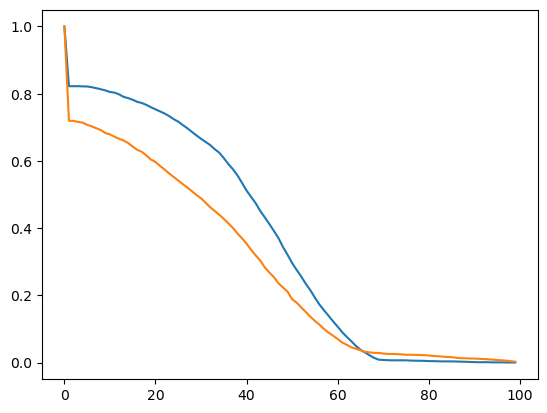

In [38]:
plt.plot(tprs)
plt.plot(fprs)

(0.0, 1.0)

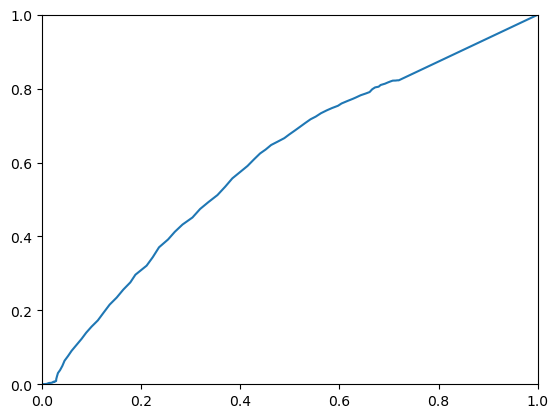

In [39]:
plt.plot(fprs,tprs)
plt.xlim([0, 1])
plt.ylim([0, 1])

In [53]:
index = 41
print(correct_genus_rate[index])
print(correct_species_rate[index])

0.3168503090567052
0.30890538033395176


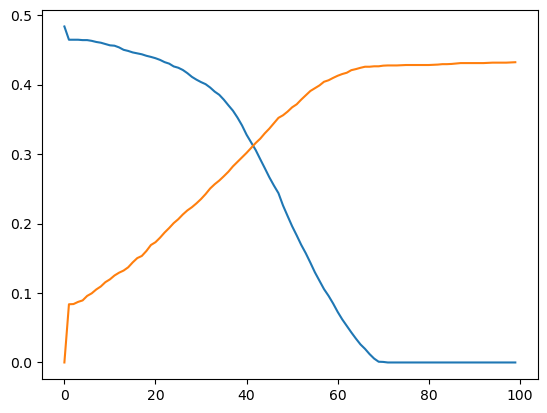

In [42]:
plt.plot(correct_genus_rate)
plt.plot(correct_species_rate)

In [28]:
real_genus = species2genus[val_labels[i]]
        predicted_genus = genus_of_best_species
        if val_labels[i] not in described_species_labels:#TPR
            n_undescribed_samples+=1
            if real_genus == predicted_genus and H_s > entropy_threshold:
                n_correct_genus+=1
        else:#FPR
            n_described_samples+=1
            if H_s > entropy_threshold:
                n_correct_genus+=1

IndentationError: unexpected indent (2494183266.py, line 2)